In [1]:
import pandas as pd
import bias
%matplotlib inline

# Load the data

## Corpus metadata

In [2]:
meta = pd.read_csv("data/metadata/metadata.csv", index_col="PMID")
meta.head(1)

,DOI,KEY,SOURCE,AUTHORS,YEAR,MONTH,JOURNAL,TITLE,PAGES,VOLUME,...,NUM_COORDINATES,MNI_COORDINATES,BRAINMAP_ID,BEHAVIORAL_DOMAIN,EXPERIMENT,DESCRIPTION,IMPACT_FACTOR_2018,CITATIONS,CITATIONS_PER_YEAR,N_SUBJECTS
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,NaN,"Dolan R J, 1992",BrainMap,Dolan R J|Bench C J|Brown R G|Scott L C|Fristo...,1992,Sep,JOURNAL OF NEUROLOGY NEUROSURGERY & PSYCHIATRY,Regional cerebral blood flow abnormalities in ...,768-773,55,...,7.0,"-7.66,51.87,-8.33;-5.51,56.46,-4.28;-5.48,58.9...",6030020.0,"['Action.Rest', 'Action.Rest']","['Unimpaired > Impaired', 'Impaired > Unimpair...",Patients with depression who were cognitively ...,8.327,21,0.75,10.0


## Remove papers with missing data

In [3]:
(~meta["CITATIONS_PER_YEAR"].isna()).astype(int).sum()

18155

In [4]:
meta = meta.dropna(subset=["CITATIONS_PER_YEAR"])
len(meta)

18155

In [5]:
pmids = meta.index
len(pmids)

18155

# Load document-term matrices (DTMs)

In [6]:
from collections import OrderedDict
from style import style

In [7]:
lists = pd.read_csv("data/lexicon/lists_data-driven_lr.csv", index_col=None)
lists.head()

,ORDER,CLUSTER,DOMAIN,TOKEN,R,ROC_AUC
0,1,6,MEMORY,memory,0.199004,0.655879
1,1,6,MEMORY,episodic_memory,0.174621,0.655879
2,1,6,MEMORY,declarative_memory,0.172933,0.655879
3,1,6,MEMORY,recognition_memory,0.162350,0.655879
4,1,6,MEMORY,remembering,0.157813,0.655879


In [8]:
terms, colors, domains = [], [], []
for dom in OrderedDict.fromkeys(lists["DOMAIN"]):
    dom_terms = lists.loc[lists["DOMAIN"] == dom, "TOKEN"]
    dom_terms = [term.replace("left_", "").replace("right_", "").replace("cerebellar_crus", "cerebellum").replace("cerebellar_lobules", "cerebellum").replace("cerebellar_vermis", "cerebellum") for term in dom_terms]
    dom_terms = list(OrderedDict.fromkeys(dom_terms))
    terms += dom_terms
    colors += [style.c[style.fw2c["data-driven"][style.order["data-driven"].index(dom)]]] * len(dom_terms)
    domains += [dom] * len(dom_terms)

In [9]:
terms = lists["TOKEN"]
term2colors = {term: [] for term in terms}
for term, dom in zip(lists["TOKEN"], lists["DOMAIN"]):
    color = style.c[style.fw2c["data-driven"][style.order["data-driven"].index(dom)]]
    if color not in term2colors[term]:
        term2colors[term].append(color)

## DTM from full texts

In [10]:
dtm_full = pd.read_csv("data/text/dtm_fulltexts_psyc.csv.gz", index_col=0)
dtm_full = dtm_full.loc[pmids, terms]
# dtm_full = (dtm_full > 0).astype(int)
dtm_full.head(5)

,memory,episodic_memory,declarative_memory,recognition_memory,remembering,emotion,fear,recognition,emotional_memory,encoding,...,intonation,audition,pitch_discrimination,language_comprehension,articulation,phonetics,word,semantic_processing,syntax,voice_perception
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,1,0,0,0,0,0,0,2,0,1,...,0,0,1,3,1,0,38,15,0,0
1486460,3,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,143,2,0,0


In [11]:
dtm_full_tfidf = bias.tfidf(dtm_full)
dtm_full_tfidf.head()

/Users/ehbeam/Documents/Stanford/PhD/Repos/nke-bias/bias.py:88: RuntimeWarning: invalid value encountered in true_divide
  tfs = (df.values.T / doc_totals.values.T)


,memory,episodic_memory,declarative_memory,recognition_memory,remembering,emotion,fear,recognition,emotional_memory,encoding,...,intonation,audition,pitch_discrimination,language_comprehension,articulation,phonetics,word,semantic_processing,syntax,voice_perception
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.106700,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
1410086,0.000000,0.0,0.0,0.0,0.0,0.308815,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
1448149,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.266751,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
1486459,0.001711,0.0,0.0,0.0,0.0,0.000000,0.0,0.006586,0.0,0.002889,...,0.0,0.0,0.012674,0.026172,0.009317,0.0,0.061680,0.096278,0.0,0.0
1486460,0.002938,0.0,0.0,0.0,0.0,0.000000,0.0,0.007541,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.132869,0.007348,0.0,0.0


## DTM from abstracts

In [12]:
dtm_abs = pd.read_csv("data/text/dtm_abstracts_psyc.csv.gz", index_col=0)
dtm_abs = dtm_abs.loc[pmids, terms]
# dtm_abs = (dtm_abs > 0).astype(int)
dtm_abs.head(5)

,memory,episodic_memory,declarative_memory,recognition_memory,remembering,emotion,fear,recognition,emotional_memory,encoding,...,intonation,audition,pitch_discrimination,language_comprehension,articulation,phonetics,word,semantic_processing,syntax,voice_perception
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1410086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1448149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,0


In [13]:
dtm_abs_tfidf = bias.tfidf(dtm_abs)
dtm_abs_tfidf.head()

,memory,episodic_memory,declarative_memory,recognition_memory,remembering,emotion,fear,recognition,emotional_memory,encoding,...,intonation,audition,pitch_discrimination,language_comprehension,articulation,phonetics,word,semantic_processing,syntax,voice_perception
PMID,,,,,,,,,,,,,,,,,,,,,
1402966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1410086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1448149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1486459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1486460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.666215,0.0,0.0,0.0


# Assess encrichment in top articles

## Compute -log(p)

In [14]:
n = meta["CITATIONS_PER_YEAR"].sort_values(ascending=False)
top_n = list(n.index[:int(len(n)/2)])
bot_n = list(n.index[int(len(n)/2):])
len(top_n)

9077

In [15]:
len(bot_n)

9078

In [16]:
len(domains)

112

In [17]:
df_full = bias.compute_bias_fdr(dtm_full, domains, top_n, "citations_psyc_full")
df_full.sort_values("FDR").head()

,TERM,DOMAIN,P,-log10(P),FDR,ORDER
22,reward,REWARD,1.732705e-21,20.761275,1.940630e-19,1
51,salience,COGNITION,5.295192e-18,17.276118,2.965308e-16,2
30,arousal,COGNITION,4.094949e-16,15.387751,1.146586e-14,2
20,arousal,MEMORY,4.094949e-16,15.387751,1.146586e-14,0
6,fear,MEMORY,7.315880e-13,12.135733,1.638757e-11,0


## Plot -log(p)

In [18]:
fdr_thres = 1e-5

In [19]:
df_full_thres = df_full.loc[df_full["FDR"] < fdr_thres]
len(df_full_thres)

14

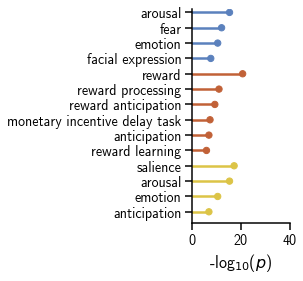

In [20]:
bias.plot_dots(df_full_thres, "citations_psyc_full", xrange=list(range(0,50,20)), 
               width=1.75, height=0.175*len(df_full_thres) + 1.5, font_size=14)

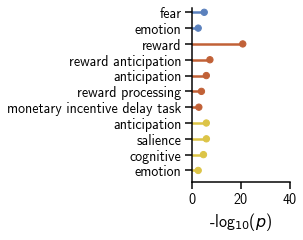

In [21]:
df_abs = bias.compute_bias_fdr(dtm_abs, domains, top_n, "citations_psyc_abs")
df_abs_thres = df_abs.loc[df_abs["FDR"] < 0.05]
bias.plot_dots(df_abs_thres, "citations_psyc_abs", xrange=list(range(0,50,20)), 
               width=1.75, height=0.175*len(df_full_thres) + 0.75, font_size=14)

# Plot coordinates vs. full texts

In [22]:
import numpy as np
from style import style

In [23]:
terms = set(dtm_full.columns)
freq = pd.DataFrame({"abstracts": dtm_abs[terms].sum(), "full_texts": dtm_full[terms].sum()})
freq.sort_values("abstracts", ascending=False).head(10)

,abstracts,full_texts
cognitive,5647,96273
face,5428,128325
word,4871,149807
word,4871,149807
word,4871,149807
memory,4223,104348
memory,4223,104348
memory,4223,104348
action,3843,80133
movement,3548,95544


In [24]:
line_func = np.poly1d(np.polyfit(freq["full_texts"], freq["abstracts"], 1))
residuals = []
for x, y in zip(freq["full_texts"], freq["abstracts"]):
    y_pred = line_func(x)
    residual = y - y_pred
    residuals.append(residual)
freq["residual"] = residuals
freq.sort_values("residual", ascending=False).head(10)

,abstracts,full_texts,residual
cognitive,5647,96273,1862.024392
reward,3328,65737,727.040758
action,3843,80133,683.843888
language,3467,71154,655.999604
encoding,2838,60711,431.921104
encoding,2838,60711,431.921104
face,5428,128325,400.225973
cognitive_control,1370,23911,390.820575
retrieval,2396,53029,287.786368
retrieval,2396,53029,287.786368


In [25]:
freq.sort_values("residual").head(10)

,abstracts,full_texts,residual
word,4871,149807,-989.726594
word,4871,149807,-989.726594
word,4871,149807,-989.726594
reaction_time,668,29190,-515.869705
reaction_time,668,29190,-515.869705
hand,2355,69584,-395.124521
picture,1950,57961,-349.449180
picture,1950,57961,-349.449180
vision,271,14046,-325.669554
valence,836,25882,-219.603851


In [26]:
mu = np.mean(freq["residual"])
sd = np.std(freq["residual"])
freq.index = [term.replace("_anterior", ",_anterior").replace("_posterior", ",_posterior") for term in freq.index]
outliers = freq.loc[freq["residual"] > (mu + sd)].index
terms_to_label = list(set(outliers).intersection(set(df_abs_thres["TERM"].append(df_full_thres["TERM"]))))
terms_to_label

['reward', 'cognitive']

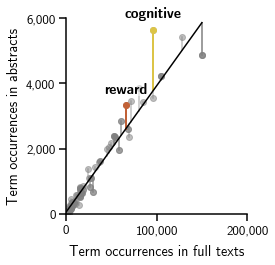

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from style import style

font = style.font
font_bold = style.font_bold

prop_ax = font_manager.FontProperties(fname=font, size=13)
prop_dot = font_manager.FontProperties(fname=font_bold, size=14)
prop_lab = font_manager.FontProperties(fname=font, size=14)

rcParams["axes.linewidth"] = 1.5

fig, ax = plt.subplots(figsize=(3.25, 3.6))

x = freq["full_texts"]
y = freq["abstracts"]

plt.scatter(x, y, color="gray", alpha=0.5)

line_x = np.unique(x)
line_y = line_func(line_x)
for x, y in zip(freq["full_texts"], freq["abstracts"]):
    plt.plot([x, x], [y, line_func(x)], color="gray", alpha=0.5, linewidth=1.5)

terms_to_label = freq["residual"].sort_values().index[-2:]
for term in terms_to_label:
    row = freq.loc[term]
    x = row["full_texts"]
    y = row["abstracts"]
    plt.text(x, y+375, term.replace("_", " "), fontproperties=prop_dot, ha="center",
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="white", linewidth=0, boxstyle="round", pad=0))
    plt.scatter(x, y, color="white", alpha=1, s=25)
    plt.plot([x, x], [y, line_func(x)], color="white", alpha=1, linewidth=1.5)
    for color in term2colors[term]:
        plt.plot([x, x], [y, line_func(x)], color=color, alpha=1, linewidth=2)
        plt.scatter(x, y, color=color, alpha=1)

plt.plot(line_x, line_y, color="black", alpha=1, linewidth=1.5)
        
ax.set_xticks(range(0, 300000, 100000))
ax.set_yticks(range(0, 8000, 2000))

ax.set_xticklabels([format(v, ",d") for v in range(0, 300000, 100000)], fontproperties=prop_ax)
ax.set_yticklabels([format(v, ",d") for v in range(0, 8000, 2000)], fontproperties=prop_ax)

plt.xlim([0, 200000])
plt.ylim([0, 6000])

for side in ["right", "top"]:
    ax.spines[side].set_visible(False)

ax.xaxis.set_tick_params(width=1.5, length=7)
ax.yaxis.set_tick_params(width=1.5, length=7)

ax.set_xlabel("Term occurrences in full texts", fontproperties=prop_lab, labelpad=7.5)
ax.set_ylabel("Term occurrences in abstracts", fontproperties=prop_lab, labelpad=5)

plt.savefig("figures/occ_psyc_full_abs.png", dpi=250, bbox_inches="tight")
plt.show()

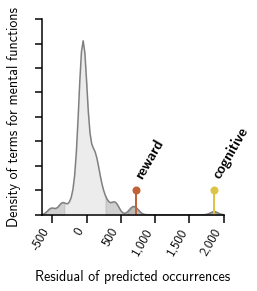

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from style import style
import seaborn as sns

font = style.font
font_bold = style.font_bold

prop_ax = font_manager.FontProperties(fname=font, size=13)
prop_dot = font_manager.FontProperties(fname=font_bold, size=14)
prop_lab = font_manager.FontProperties(fname=font, size=14)

rcParams["axes.linewidth"] = 1.5

fig, ax = plt.subplots(figsize=(3.25, 3.6))

sns.distplot(freq["residual"], hist=False, kde=True, 
             bins=20, color="gray", 
             hist_kws={"edgecolor":"black"},
             kde_kws={"linewidth": 1.5, "color":"gray"})

l = ax.lines[0]
x = l.get_xydata()[:,0]
y = l.get_xydata()[:,1]

mu = np.mean(freq["residual"])
sd = np.std(freq["residual"])

ax.fill_between(x, y, color="gray", alpha=0.15)

for n_sd in range(-3, 0):
    pos = mu + (n_sd * sd)
    closest_x = min(x, key=lambda list_value : abs(list_value - pos))
    idx = list(x).index(closest_x)
    ax.fill_between(x[:idx], y[:idx], color="gray", alpha=0.25)

for n_sd in range(1, 4):
    pos = mu + (n_sd * sd)
    closest_x = min(x, key=lambda list_value : abs(list_value - pos))
    idx = list(x).index(closest_x)
    ax.fill_between(x[idx-1:], y[idx-1:], color="gray", alpha=0.25)

nudges = [0, 0] # [-60, 60, 0]
for i, term in enumerate(terms_to_label):
    row = freq.loc[term]
    x = row["residual"]
    y = 0.0005
    plt.text(x-60+nudges[i], y+0.00025, term.replace("_", " "), rotation=60, fontproperties=prop_dot, ha="left")
    for color in term2colors[term]:
        plt.plot([x, x], [0, y], color=color, linewidth=2, alpha=1)
        plt.scatter(x, y, color=color, linewidth=2, alpha=1)
    
ax.set_xlim([-650, 2000])
ax.set_ylim([0, 0.004])

ax.set_xticklabels([format(int(v), ",d") for v in plt.xticks()[0]], 
                   rotation=60, fontproperties=prop_ax, ha="right")
ax.set_yticklabels([], fontproperties=prop_ax)

for side in ["right", "top"]:
    ax.spines[side].set_visible(False)

ax.xaxis.set_tick_params(width=1.5, length=7.5)
ax.yaxis.set_tick_params(width=1.5, length=7.5)

ax.set_xlabel("Residual of predicted occurrences", fontproperties=prop_lab, labelpad=12.5)
ax.set_ylabel("Density of terms for mental functions", fontproperties=prop_lab, labelpad=10)

plt.savefig("figures/resid_psyc_full_abs.png", dpi=250, bbox_inches="tight")
plt.show()

# Relate citations with occurrences

In [29]:
from scipy import stats

In [30]:
cor_full = []
for term in terms:
    occs = dtm_full[term].astype(float)
    if len(occs.shape) > 1:
        occs = occs.loc[:,~occs.columns.duplicated()]
    r, p = stats.spearmanr(occs, meta["CITATIONS"].astype(float))
    if r > 0 and p < 0.001:
        print("{:30s} r={:1.4f} p={:1.4f}".format(term, r, p))
    cor_full.append(r)

pitch_discrimination           r=0.0433 p=0.0000
reward_anticipation            r=0.0303 p=0.0000
manipulation                   r=0.0287 p=0.0001
monitoring                     r=0.0360 p=0.0000
anticipation                   r=0.0371 p=0.0000
fear                           r=0.0250 p=0.0008
response_selection             r=0.0396 p=0.0000
error_detection                r=0.0472 p=0.0000
rehearsal                      r=0.0429 p=0.0000
covert                         r=0.0302 p=0.0000
arousal                        r=0.0622 p=0.0000
facial_expression              r=0.0337 p=0.0000
monetary_incentive_delay_task  r=0.0353 p=0.0000


In [31]:
cor_abs = []
for term in terms:
    occs = dtm_abs[term].astype(float)
    if len(occs.shape) > 1:
        occs = occs.loc[:,~occs.columns.duplicated()]
    r, p = stats.spearmanr(occs, meta["CITATIONS"].astype(float))
    if r > 0 and p < 0.001:
        print("{:30s} r={:1.4f} p={:1.4f}".format(term, r, p))
    cor_abs.append(r)

reward                         r=0.0470 p=0.0000
reward_anticipation            r=0.0348 p=0.0000
anticipation                   r=0.0373 p=0.0000


In [32]:
cor = pd.DataFrame({"abstracts": cor_abs, "full_texts": cor_full}, index=terms)
cor.sort_values("abstracts", ascending=False).head(10)

,abstracts,full_texts
reward,0.047017,0.017300
anticipation,0.037254,0.037054
reward_anticipation,0.034797,0.030294
fear,0.022588,0.024962
manipulation,0.020412,0.028705
error_detection,0.020043,0.047244
covert,0.017879,0.030197
monitoring,0.017219,0.036003
monetary_incentive_delay_task,0.016984,0.035261
face,0.015555,0.020083


In [33]:
line_func = np.poly1d(np.polyfit(cor["full_texts"], cor["abstracts"], 1))
residuals = []
for x, y in zip(cor["full_texts"], cor["abstracts"]):
    y_pred = line_func(x)
    residual = y - y_pred
    residuals.append(residual)
cor["residual"] = residuals
cor.sort_values("residual", ascending=False).head(10)

,abstracts,full_texts,residual
reward,0.047017,0.017300,0.040229
reward_anticipation,0.034797,0.030294,0.023001
anticipation,0.037254,0.037054,0.022852
intonation,0.011643,-0.013262,0.016635
fear,0.022588,0.024962,0.012847
speech,0.012397,0.001434,0.011725
decision,-0.008758,-0.053341,0.011682
reward_processing,0.011729,0.000916,0.011256
decision_making,0.001448,-0.025502,0.011158
grasping,0.009628,-0.002720,0.010557


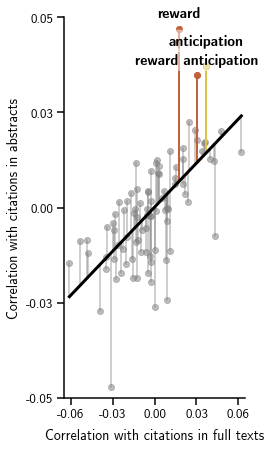

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from style import style

font = style.font
font_bold = style.font_bold

prop_ax = font_manager.FontProperties(fname=font, size=13)
prop_dot = font_manager.FontProperties(fname=font_bold, size=14)
prop_lab = font_manager.FontProperties(fname=font, size=14)

rcParams["axes.linewidth"] = 1.5

fig, ax = plt.subplots(figsize=(3.25, 7))

x = cor["full_texts"]
y = cor["abstracts"]

plt.scatter(x, y, color="gray", alpha=0.5)

line_x = np.unique(x)
line_y = line_func(line_x)
for x, y in zip(cor["full_texts"], cor["abstracts"]):
    plt.plot([x, x], [y, line_func(x)], color="gray", alpha=0.5, linewidth=1.5)

nudges = [0.0025, 0, 0]
terms_to_label = cor["residual"].sort_values().index[-3:]
for i, term in enumerate(terms_to_label):
    row = cor.loc[term]
    x = row["full_texts"]
    y = row["abstracts"]
    plt.text(x, y+0.003+nudges[i], term.replace("_", " "), fontproperties=prop_dot, ha="center",
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="white", linewidth=0, boxstyle="round"))
    plt.scatter(x, y, color="white", alpha=1, s=25)
    plt.plot([x, x], [y, line_func(x)], color="white", alpha=1, linewidth=1.5)
    for color in term2colors[term]:
        plt.plot([x, x], [y, line_func(x)], color=color, alpha=1, linewidth=2)
        plt.scatter(x, y, color=color, alpha=1)

plt.plot(line_x, line_y, color="black", alpha=1, linewidth=3)
        
xrange = [-0.06, -0.03, 0, 0.03, 0.06]
yrange = [-0.05, -0.025, 0, 0.025, 0.05]
ax.set_xticks(xrange)
ax.set_yticks(yrange)

ax.set_xticklabels(["{:1.2f}".format(v) for v in xrange], fontproperties=prop_ax)
ax.set_yticklabels(["{:1.2f}".format(v) for v in yrange], fontproperties=prop_ax)

plt.xlim([-0.065, 0.065])
plt.ylim([yrange[0], yrange[-1]])

for side in ["right", "top"]:
    ax.spines[side].set_visible(False)

ax.xaxis.set_tick_params(width=1.5, length=7)
ax.yaxis.set_tick_params(width=1.5, length=7)

ax.set_xlabel("Correlation with citations in full texts", fontproperties=prop_lab, labelpad=7.5)
ax.set_ylabel("Correlation with citations in abstracts", fontproperties=prop_lab, labelpad=5)

plt.savefig("figures/cor_psyc_full_abs.png", dpi=250, bbox_inches="tight")
plt.show()

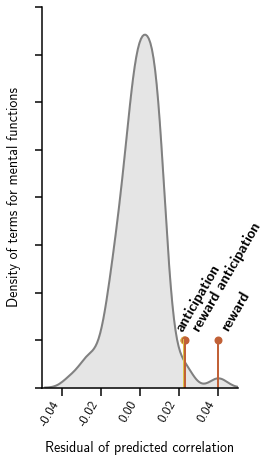

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from style import style
import seaborn as sns

font = style.font
font_bold = style.font_bold

prop_ax = font_manager.FontProperties(fname=font, size=13)
prop_dot = font_manager.FontProperties(fname=font_bold, size=14)
prop_lab = font_manager.FontProperties(fname=font, size=14)

rcParams["axes.linewidth"] = 1.5

fig, ax = plt.subplots(figsize=(3.5, 7))

sns.distplot(cor["residual"], hist=False, kde=True, 
             bins=20, color="gray", 
             hist_kws={"edgecolor":"black"},
             kde_kws={"linewidth": 2, "color":"gray"})

l1 = ax.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
ax.fill_between(x1,y1, color="gray", alpha=0.2)

nudges = [-0.0055, 0.0025, 0]
for i, term in enumerate(terms_to_label):
    row = cor.loc[term]
    x = row["residual"]
    y = 0.0005
    plt.text(x+nudges[i], y+6, term.replace("_", " "), rotation=60, fontproperties=prop_dot, ha="left")
    for color in term2colors[term]:
        plt.plot([x, x], [0, y+5], color=color, linewidth=2, alpha=1)
        plt.scatter(x, y+5, color=color, linewidth=2, alpha=1)
    
ax.set_xlim([-0.05, 0.05])
ax.set_ylim([0, 40])

ax.set_xticklabels(["{:1.2f}".format(v) for v in plt.xticks()[0]], 
                   rotation=60, fontproperties=prop_ax, ha="right")
ax.set_yticklabels([], fontproperties=prop_ax)

for side in ["right", "top"]:
    ax.spines[side].set_visible(False)

ax.xaxis.set_tick_params(width=1.5, length=7.5)
ax.yaxis.set_tick_params(width=1.5, length=7.5)

ax.set_xlabel("Residual of predicted correlation", fontproperties=prop_lab, labelpad=12.5)
ax.set_ylabel("Density of terms for mental functions", fontproperties=prop_lab, labelpad=10)

plt.savefig("figures/cor_resid_psyc_abs_full.png", dpi=250, bbox_inches="tight")
plt.show()